In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import cv2
import time
import os

In [148]:
class Vehicle:
    def __init__(self, current_x, current_v, current_s,vehicle_length, delta_t, lane_length, global_clock):
        self.current_x = current_x
        self.current_v = current_v
        self.current_a = 0
        self.current_s = 10000  # Initially set to a large value
        self.delta_t = delta_t
        self.vehicle_length = vehicle_length
        self.lane_length = lane_length

        self.history_t = [global_clock]
        self.history_x = [current_x]
        self.history_v = [current_v]
        self.history_a = [0]
        self.history_s = [current_s]
        self.history_delta_v = []

        # IDM parameters
        self.v0 = 25 + np.random.normal(0,1) # Desired velocity
        self.T = 1.5    # Safe time headway
        self.a = 0.3    # Maximum acceleration
        self.b = 3    # Comfortable deceleration
        self.delta = 4  # Acceleration exponent
        self.s0 = 2     # Minimum gap
        self.red_visual_distance = np.random.normal(100, 5)  # Distance at which vehicle will stop for red light
        self.stopped_at_red = False
        self.stop_for_red = True

    def update(self, lead_vehicle, is_red_light, global_clock):

        # Update s (distance to leading vehicle or traffic light)
        if lead_vehicle:
            self.current_s = lead_vehicle.current_x - self.current_x - lead_vehicle.vehicle_length
        elif is_red_light and self.stop_for_red:
            self.current_s = max(0, self.lane_length - self.current_x)
        else:
            self.current_s = 10000  # Large value for free driving

        # Calculate acceleration using IDM
        lead_v = lead_vehicle.current_v if lead_vehicle else self.v0
        if is_red_light and self.stop_for_red and self.current_s < self.red_visual_distance :  # Close to red light
            lead_v = 0
        delta_v = self.current_v - lead_v
        s_star = (self.s0 + max(0, self.current_v * self.T + 
                  (self.current_v * delta_v) / 
                  (2 * np.sqrt(self.a * self.b))))
        
        self.current_a = self.a * (1 - (self.current_v / self.v0)**self.delta - (s_star / max(self.current_s, 0.01))**2)
        if self.current_a < -8:
            self.current_a = -8
        if self.current_a > 3:
            self.current_a = 3
        # Update velocity and position
        self.current_v = max(0, self.current_v + self.current_a * self.delta_t)
        self.current_x = min(self.lane_length, self.current_x + self.current_v * self.delta_t)

        # Save to history
        self.history_t.append(global_clock)
        self.history_x.append(self.current_x)
        self.history_v.append(self.current_v)
        self.history_a.append(self.current_a)
        self.history_s.append(self.current_s)
        self.history_delta_v.append(delta_v)

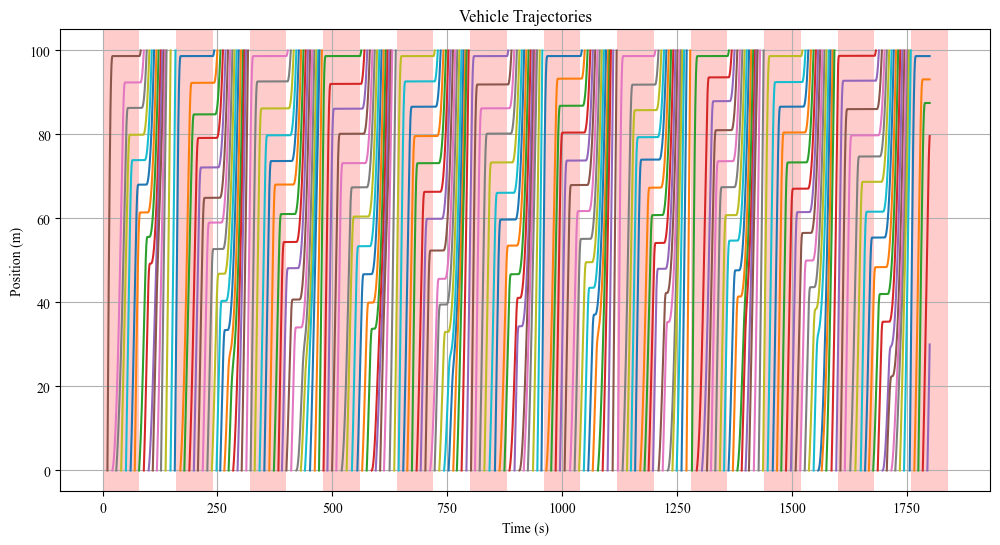

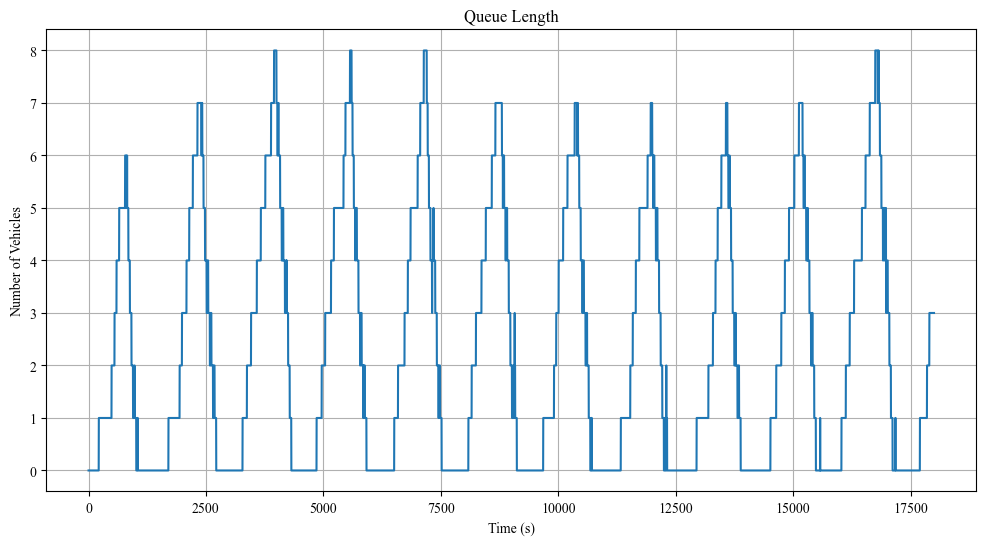

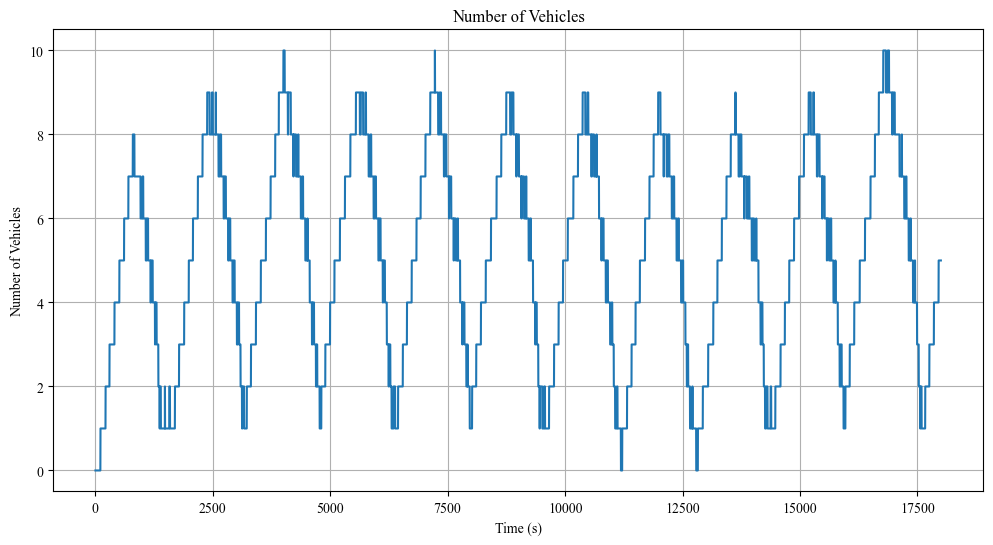

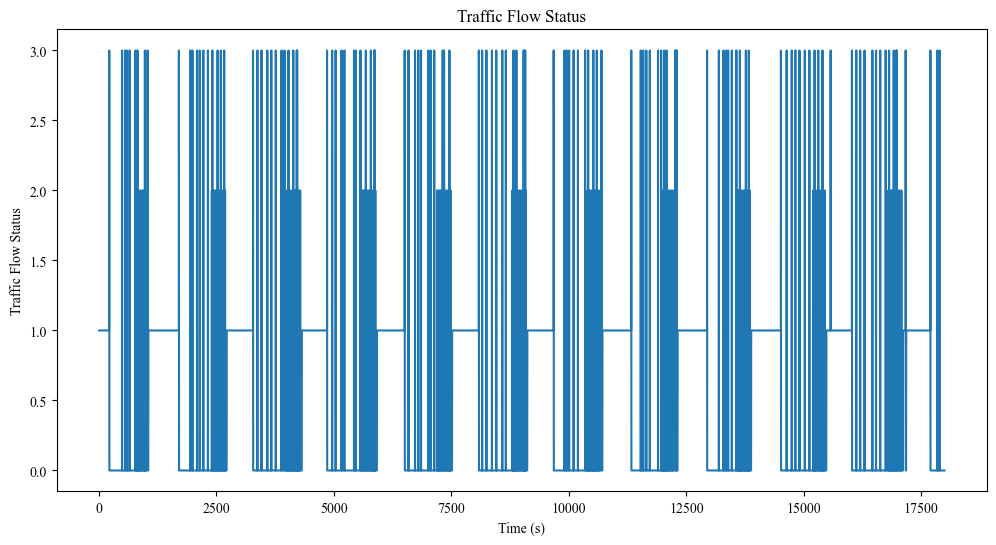

In [226]:

def run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway):
    # Initialize variables
    mean_vehicle_length = 5
    mean_speed = 18 # m/s

    vehicles = []
    exited_vehicles = []
    global_clock = 0
    next_vehicle_time = np.random.normal(mean_headway, 1)
    queue_record = [] # Queue of vehicles whose speed is 0
    num_vehicles = [] # Number of vehicles in the lane
    
    # Simulation loop
    while global_clock < simulation_time:
        light_cycle = red_light_time + green_light_time
        is_red_light = (global_clock % light_cycle) < red_light_time

        # Generate new vehicle if it's time
        if global_clock >= next_vehicle_time:
            vehicle_length = np.random.normal(mean_vehicle_length, 0.5)
            
            if vehicles:
                # Consider the tail car's speed and position
                tail_car = vehicles[-1]
                current_v = np.random.normal(tail_car.current_v, 1)
                # Position the new car behind the tail car, allowing negative positions
                if tail_car.current_x - tail_car.vehicle_length < 0:
                    current_x = tail_car.current_x - tail_car.vehicle_length - tail_car.s0 - 0.2 * vehicle_length
                    current_s = tail_car.s0 + 0.2 * vehicle_length
                else:
                    current_x = 0
                    current_s = tail_car.current_x - tail_car.vehicle_length
            else:
                current_v = np.random.normal(mean_speed, 5)
                if current_v < 0:
                    current_v = 1
                current_x = 0
                current_s = 10000
                
            new_vehicle = Vehicle(current_x, current_v, current_s,vehicle_length, delta_t, lane_length, global_clock)
            vehicles.append(new_vehicle)
            next_vehicle_time = global_clock + np.random.normal(mean_headway, 1)
        global_clock += delta_t
        # Update vehicles and check for exits
        i = 0
        queue_num = 0
        while i < len(vehicles):
            vehicle = vehicles[i]
            lead_vehicle = vehicles[i-1] if i > 0 else None
            vehicle.update(lead_vehicle, is_red_light, global_clock)
            # Check if vehicle has exited the lane
            if vehicle.current_x >= lane_length:
                exited_vehicles.append(vehicles.pop(i))
            else:
                i += 1
            # Check if vehicle is stopped
            if vehicle.current_v == 0:
                queue_num += 1
        queue_record.append(queue_num)
        num_vehicles.append(len(vehicles))
    queue_record = np.array(queue_record)
    num_vehicles = np.array(num_vehicles) 
    # create Traffic flow status, 
    # 0 for congested (no vehicle can move in the lane), 
    # 1 for free flow (all vehicles are moving)
    # 2 for queue resolving (queue is being resolved, the queue number is decreasing),
    # 3 for queue forming (queue is forming, the queue number is increasing)
    traffic_flow_status = [1]
    for i in range(1,len(queue_record)):
        cur_queue = queue_record[i]
        prev_queue = queue_record[i-1]
        if cur_queue == 0:
            traffic_flow_status.append(1)
        elif cur_queue > prev_queue:
            traffic_flow_status.append(3)
        elif cur_queue < prev_queue:
            traffic_flow_status.append(2)
        else:
            traffic_flow_status.append(0)
    return vehicles, exited_vehicles, queue_record, num_vehicles,traffic_flow_status

# Run simulation
lane_length = 100  # meters
red_light_time = 80  # seconds
green_light_time = 80  # seconds
simulation_time = 1800  # seconds
delta_t = 0.1  # seconds
mean_headway = 10 # seconds

vehicles, exited_vehicles, queue_record, num_vehicles,traffic_flow_status = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway)

# Plotting
plt.figure(figsize=(12, 6))
for vehicle in vehicles + exited_vehicles:
    plt.plot(vehicle.history_t, vehicle.history_x)

plt.title('Vehicle Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid(True)

# Add traffic light cycle visualization
for i in range(int(simulation_time / (red_light_time + green_light_time)) + 1):
    plt.axvspan(i * (red_light_time + green_light_time), (i * (red_light_time + green_light_time)) + red_light_time, 
                facecolor='red', alpha=0.2)

plt.show()
# plot queue length curve
plt.figure(figsize=(12, 6))
plt.plot(range(len(queue_record)), queue_record)
plt.title('Queue Length')
plt.xlabel('Time (s)')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()
# plot number of vehicles curve
plt.figure(figsize=(12, 6))
plt.plot(range(len(num_vehicles)), num_vehicles)
plt.title('Number of Vehicles')
plt.xlabel('Time (s)')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()
# plot traffic flow status
plt.figure(figsize=(12, 6))
plt.plot(range(len(traffic_flow_status)), traffic_flow_status)
plt.title('Traffic Flow Status')
plt.xlabel('Time (s)')
plt.ylabel('Traffic Flow Status')
plt.show()

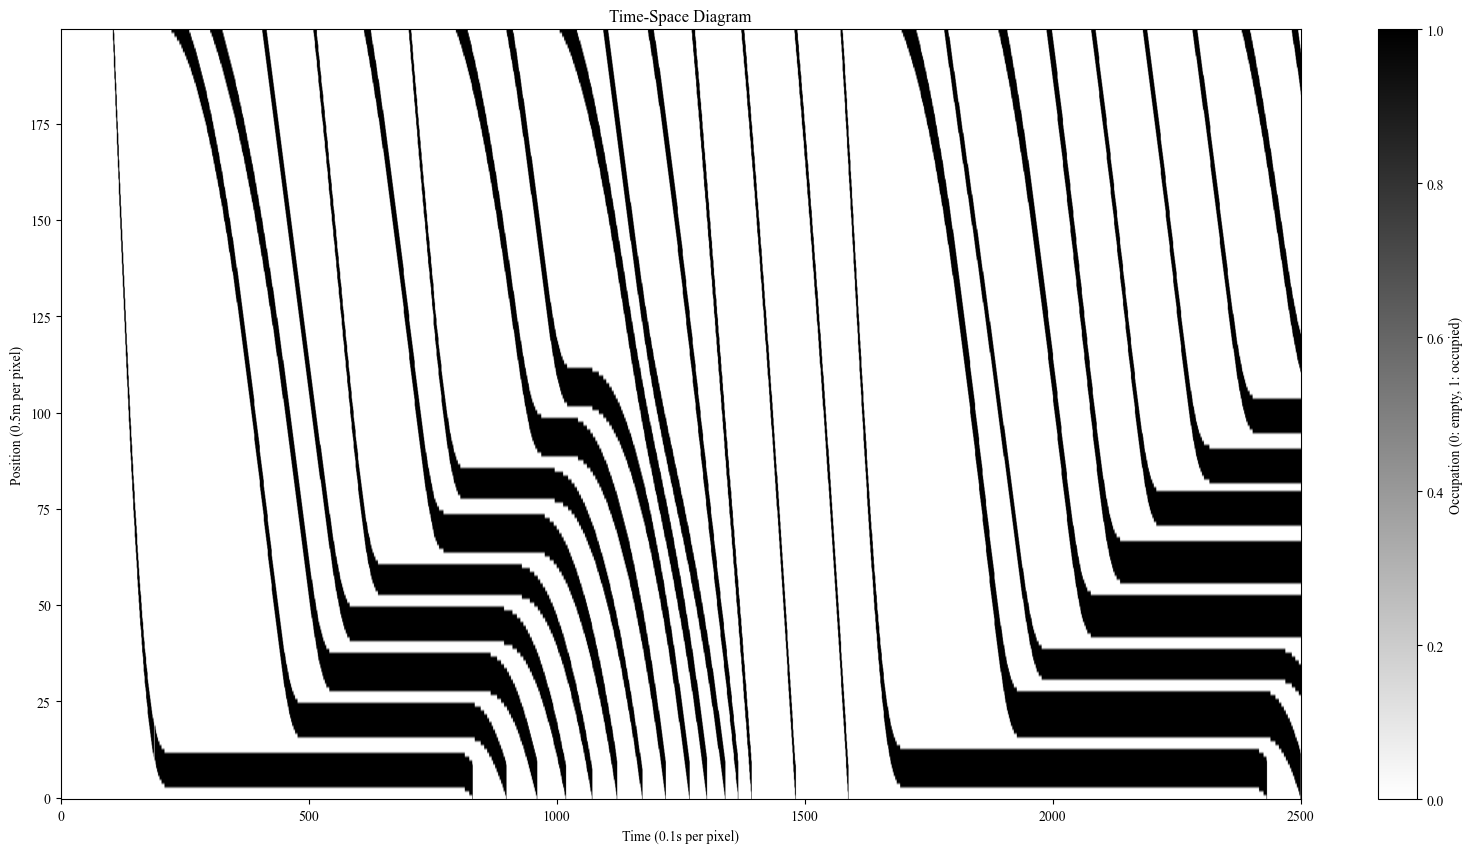

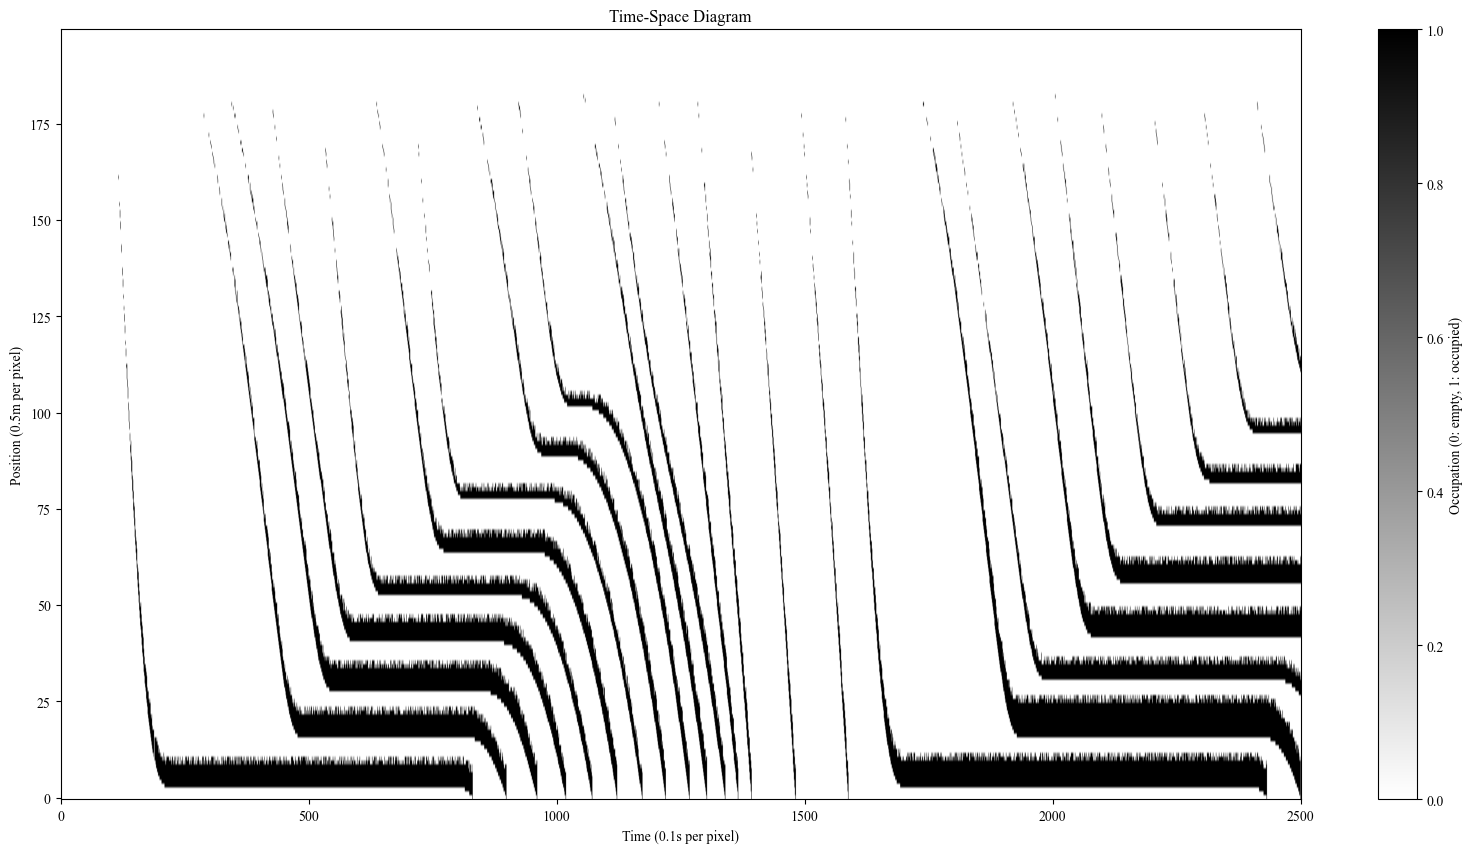

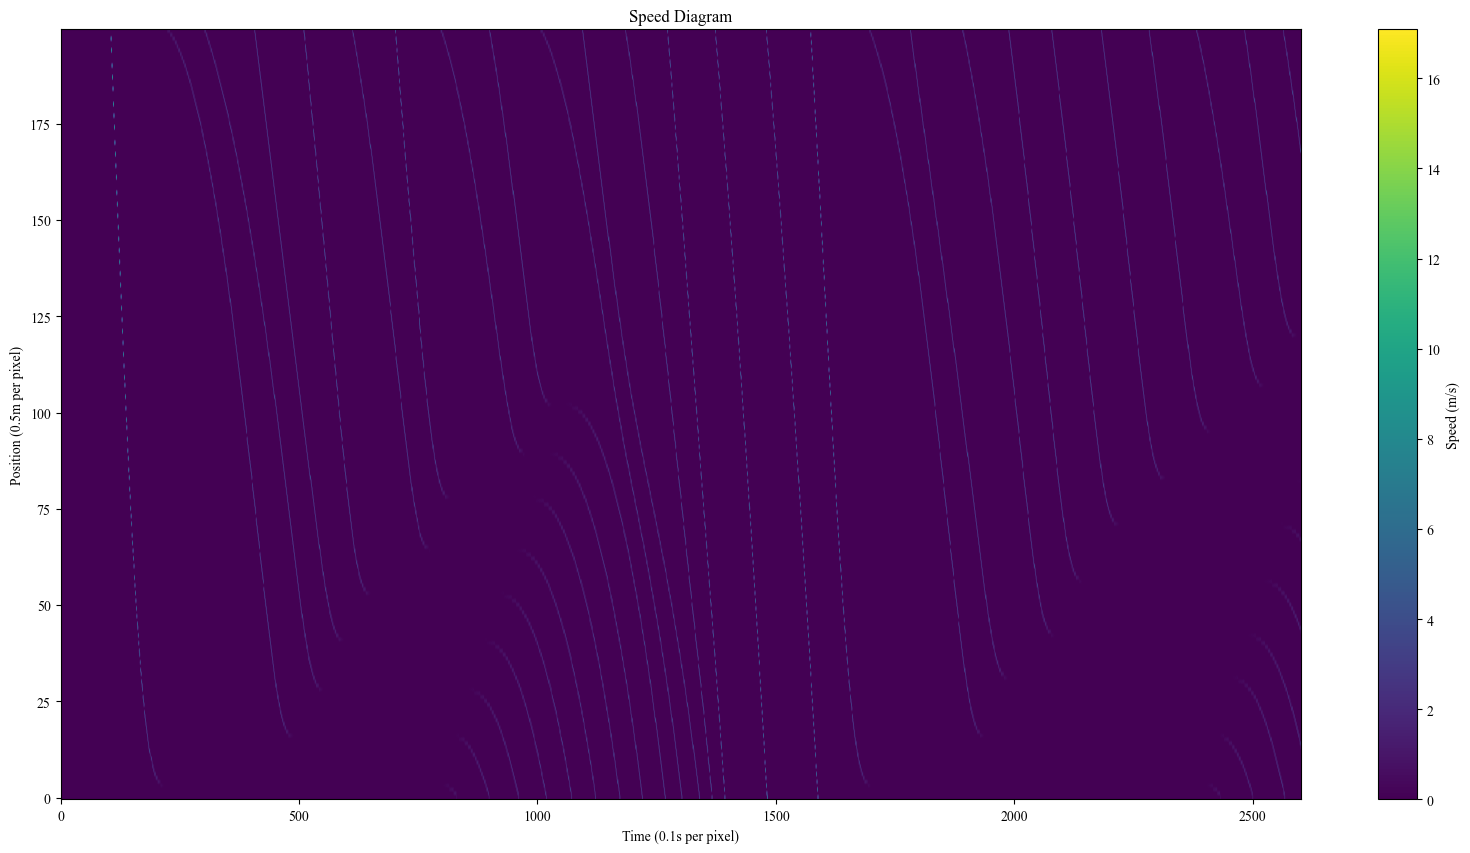

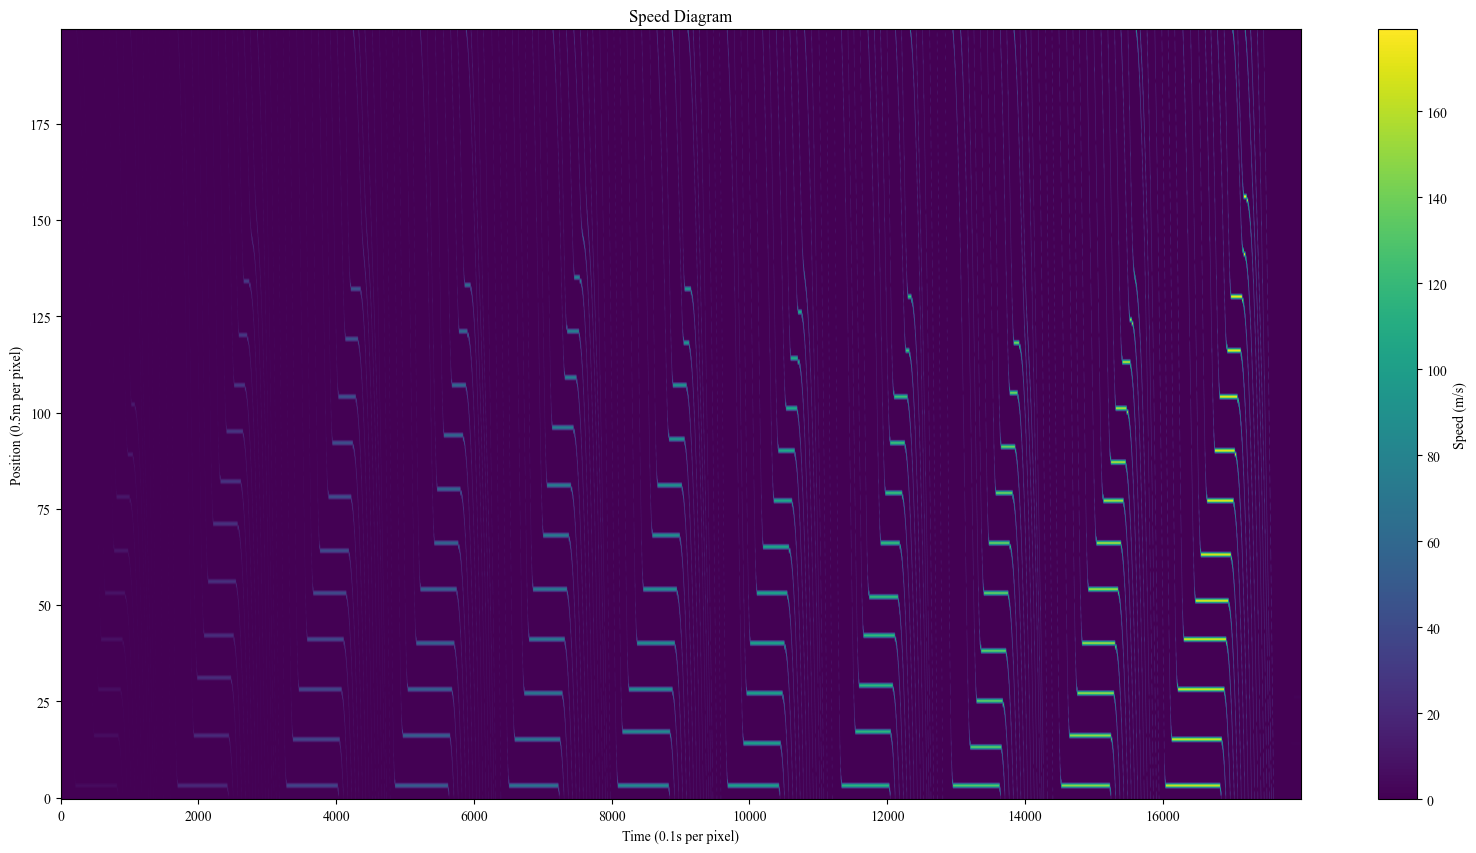

In [227]:
def create_time_space_diagram(vehicles, lane_length, simulation_time, delta_t):
    # Set up the grid
    time_resolution = 0.1  # seconds per pixel
    space_resolution = 0.5  # meters per pixel
    time_pixels = int(simulation_time / time_resolution)
    space_pixels = int(lane_length / space_resolution)
    
    # Create an empty grid
    time_space_mask = np.zeros((space_pixels, time_pixels), dtype=int)
    time_space_mask_occ_effect = np.zeros((space_pixels, time_pixels), dtype=int) # this is for simulate the effect of the vehicle length on the space (some part of the vehicle cannot be observed)
    vehicle_trajs = []
    for v_id,vehicle in enumerate(vehicles):
        vehicle_length_pixels = int(vehicle.vehicle_length / space_resolution)
        for t, x, v in zip(vehicle.history_t, vehicle.history_x, vehicle.history_v):
            time_idx = int(t / time_resolution) - 1
            space_idx = int(x / space_resolution) - 1
            if 0 <= space_idx < space_pixels:
                vehicle_trajs.append((v_id, time_idx, space_idx, v))
                # Mark the space occupied by the vehicle
                length_decay = x / lane_length
                preserved_pixels_occ = int(vehicle_length_pixels * length_decay) - np.random.randint(0,3)
                if preserved_pixels_occ < 0:
                    preserved_pixels_occ = 0
                for i in range(vehicle_length_pixels):
                    if 0 <= space_idx - i < space_pixels:
                        time_space_mask[space_idx - i, time_idx] = 1
                for i in range(preserved_pixels_occ):
                    if 0 <= space_idx - i < space_pixels:
                        time_space_mask_occ_effect[space_idx - i, time_idx] = 1
                        
    return time_space_mask,time_space_mask_occ_effect,vehicle_trajs

# After running the simulation
time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(vehicles + exited_vehicles, lane_length, simulation_time, delta_t)
# upside down the grid
time_space_mask = np.flipud(time_space_mask)
time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
plt.figure(figsize=(20, 10))
plt.imshow(time_space_mask, cmap='binary', aspect='auto', origin='lower')
plt.title('Time-Space Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')

plt.colorbar(label='Occupation (0: empty, 1: occupied)')
plt.xlim(0, 2500)
plt.show()
plt.figure(figsize=(20, 10))
plt.imshow(time_space_mask_occ_effect, cmap='binary', aspect='auto', origin='lower')
plt.title('Time-Space Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')

plt.colorbar(label='Occupation (0: empty, 1: occupied)')
plt.xlim(0, 2500)
plt.show()
# plot speed of each pixel accoridng to the trajectory
speed_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
speed_mask = np.flipud(speed_mask)
plt.figure(figsize=(20, 10))
plt.imshow(speed_mask, cmap='viridis', aspect='auto', origin='lower')
plt.title('Speed Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')
plt.colorbar(label='Speed (m/s)')
plt.xlim(0, 2600)
plt.show()
speed_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    speed_mask[vehicle[2],vehicle[1]] = vehicle[0]
speed_mask = np.flipud(speed_mask)
plt.figure(figsize=(20, 10))
plt.imshow(speed_mask, cmap='viridis', aspect='auto', origin='lower')
plt.title('Speed Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')
plt.colorbar(label='Speed (m/s)')
# plt.xlim(0, 2600)
plt.show()


In [228]:
# Randomly add some regular patches with angles to block the time_space_mask to simulate the occlusion events
def add_occlusions(binary_mask):
    # Convert binary mask to uint8 type (required for OpenCV operations)
    occluded_mask = (binary_mask * 1).astype(np.uint8)
    occlusion_mask = np.zeros_like(occluded_mask) # indicating the occlusion area where the binary mask is 1 and the occlusion is 0
    num_occlusions = occluded_mask.shape[1] // 200
    height, width = occluded_mask.shape
    for _ in range(num_occlusions):
        # Random center point
        center = (np.random.randint(0, width), np.random.randint(0, height))
        
        # Random width and height (between 5% and 20% of image dimensions)
        rect_width = int(np.random.normal(12,1))
        rect_height = int(np.random.normal(50,3))
        
        # Random angle (0 to 180 degrees)
        angle = np.random.randint(0, 30)
        
        # Create rotated rectangle
        rect = ((center[0], center[1]), (rect_width, rect_height), angle)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        
        # Fill the rotated rectangle with white (255)
        cv2.fillPoly(occlusion_mask, [box], 1)
        cv2.fillPoly(occluded_mask, [box], 0)
    # find common area of occlusion and binary mask
    occlusion_mask = occlusion_mask * binary_mask
    
    return occluded_mask,occlusion_mask

# add noise to the occulded diagram
def add_noise(binary_mask,emit_rate = 0.1,noise_rate = 0.001):
    binary_mask = binary_mask.copy()
    emit_mask = np.random.choice([0, 1], size=binary_mask.shape, p=[1-emit_rate, emit_rate])
    binary_mask[emit_mask == 1] = 0
    noise_mask = np.random.choice([0, 1], size=binary_mask.shape, p=[1-noise_rate, noise_rate])
    binary_mask[noise_mask == 1] = 1

    return binary_mask
    

In [234]:
out_folder = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0826'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
target_folder = os.path.join(out_folder, 'target')
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
post_occ_label_folder = os.path.join(out_folder, 'post_occ_label')
if not os.path.exists(post_occ_label_folder):
    os.makedirs(post_occ_label_folder)
speed_label_folder = os.path.join(out_folder, 'speed_label')
if not os.path.exists(speed_label_folder):
    os.makedirs(speed_label_folder)

delta_t = 0.1  # seconds
simulation_time = 1800  # seconds
lane_length = 100  # meters
past_frames = 100
pred_frames = 50
simulation_repeat = 0
total_sampled_data_num = 50000
current_sampled_data_num = 0
total_sampled_flow_status = []
while True:
    # Run simulation
    
    red_light_time = int(50 + np.random.randint(0,15)) # seconds
    green_light_time = int(60 + np.random.normal(0,15)) # seconds
    while red_light_time < 0 or green_light_time < 0:
        red_light_time = int(50 + np.random.randint(0,15)) # seconds
        green_light_time = int(60 + np.random.normal(0,15)) # seconds

    mean_headway = 15 + np.random.normal(0,4) # seconds

    vehicles, exited_vehicles, queue_record, num_vehicles,traffic_flow_status = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway)
    total_vehicles = vehicles + exited_vehicles
    # After running the simulation
    time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(total_vehicles, lane_length, simulation_time, delta_t)
    # upside down the grid
    time_space_mask = np.flipud(time_space_mask)
    time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
    occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
    noised = add_noise(occluded_diagram)
    speed_mask = np.zeros((time_space_mask.shape))
    for vehicle in vehicle_trajs:
        speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
    speed_mask = np.flipud(speed_mask)
    track_mask = np.zeros((time_space_mask.shape))
    for vehicle in vehicle_trajs:
        track_mask[vehicle[2],vehicle[1]] = 1
    track_mask = np.flipud(track_mask)
    overall_status = np.c_[traffic_flow_status,queue_record,num_vehicles]
    unique_overall_status,counts = np.unique(overall_status, axis=0, return_counts=True)
    # evenly sample the time points according to the traffic flow unique_overall_status
    selected_time_points = []
    for i in range(len(unique_overall_status)):
        if counts[i] > 1:
            selected_time_points.append(np.random.choice(np.where((overall_status == unique_overall_status[i]).all(axis=1))[0],1,replace=False))
        else:
            selected_time_points.append(np.where((overall_status == unique_overall_status[i]).all(axis=1))[0])
    # sample 10 time points for for free flow
    traffic_flow_status = np.array(traffic_flow_status)
    free_flow_time_points = np.where(traffic_flow_status == 1)[0]
    selected_time_points.append(np.random.choice(free_flow_time_points,10,replace=False))
    selected_time_points = np.concatenate(selected_time_points)
    for t in selected_time_points:

        if t > time_space_mask.shape[1] - past_frames:
            t = time_space_mask.shape[1] - past_frames
        if t < past_frames:
            t = past_frames
        target = time_space_mask[:,t - past_frames:t]
        occ_diagram = noised[:,t - past_frames:t]
        speed_label = speed_mask[:,t - past_frames:t]
        track_label = track_mask[:,t - past_frames:t]
        np.save(os.path.join(target_folder, f'{simulation_repeat}_{t}.npy'), track_label)
        np.save(os.path.join(post_occ_label_folder, f'{simulation_repeat}_{t}.npy'), occ_diagram)
        np.save(os.path.join(speed_label_folder, f'{simulation_repeat}_{t}.npy'), speed_label)
        current_sampled_data_num += 1
        
    if current_sampled_data_num >= total_sampled_data_num:
        break

    simulation_repeat += 1
    

KeyboardInterrupt: 

In [ ]:
    # create Traffic flow status, 
    # 0 for congested (no vehicle can move in the lane), 
    # 1 for free flow (all vehicles are moving)
    # 2 for queue resolving (queue is being resolved, the queue number is decreasing),
    # 3 for queue forming (queue is forming, the queue number is increasing)

In [230]:
# split into train and val set in 8:2 ratio
from tqdm import tqdm
import shutil
import random
import os

out_folder = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug'
target_folder = os.path.join(out_folder, 'target')
post_occ_label_folder = os.path.join(out_folder, 'post_occ_label')
# occ_mask_folder = os.path.join(out_folder, 'occ_mask_label')
speed_label_folder = os.path.join(out_folder, 'speed_label')

train_folder = os.path.join(out_folder, 'train')
val_folder = os.path.join(out_folder, 'val')
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(val_folder):
    os.makedirs(val_folder)

train_target_folder = os.path.join(train_folder, 'target')
val_target_folder = os.path.join(val_folder, 'target')
train_post_occ_label_folder = os.path.join(train_folder, 'post_occ_label')
val_post_occ_label_folder = os.path.join(val_folder, 'post_occ_label')
# train_occ_mask_folder = os.path.join(train_folder, 'occ_mask_label')
# val_occ_mask_folder = os.path.join(val_folder, 'occ_mask_label')
train_speed_label_folder = os.path.join(train_folder, 'speed_label')
val_speed_label_folder = os.path.join(val_folder, 'speed_label')
if not os.path.exists(train_target_folder):
    os.makedirs(train_target_folder)
if not os.path.exists(val_target_folder):
    os.makedirs(val_target_folder)
if not os.path.exists(train_post_occ_label_folder):
    os.makedirs(train_post_occ_label_folder)
if not os.path.exists(val_post_occ_label_folder):
    os.makedirs(val_post_occ_label_folder)
if not os.path.exists(train_speed_label_folder):
    os.makedirs(train_speed_label_folder)
if not os.path.exists(val_speed_label_folder):
    os.makedirs(val_speed_label_folder)

# get all the files
target_list = os.listdir(target_folder)
# shuffle the files
random.shuffle(target_list)
# split into train and val set
train_num = int(len(target_list) * 0.8)

train = target_list[:train_num]
val = target_list[train_num:]


# copy the files to train and val folders
for arr in tqdm(train):
    shutil.copy(os.path.join(target_folder, arr), os.path.join(train_target_folder, arr))
    shutil.copy(os.path.join(post_occ_label_folder, arr), os.path.join(train_post_occ_label_folder, arr))
    shutil.copy(os.path.join(speed_label_folder, arr), os.path.join(train_speed_label_folder, arr))
    # shutil.copy(os.path.join(occ_mask_folder, arr), os.path.join(train_occ_mask_folder, arr))


for arr in tqdm(val):
    shutil.copy(os.path.join(target_folder, arr), os.path.join(val_target_folder, arr))
    shutil.copy(os.path.join(post_occ_label_folder, arr), os.path.join(val_post_occ_label_folder, arr))
    shutil.copy(os.path.join(speed_label_folder, arr), os.path.join(val_speed_label_folder, arr))
    # shutil.copy(os.path.join(occ_mask_folder, arr), os.path.join(val_occ_mask_folder, arr))


100%|██████████| 9929/9929 [03:00<00:00, 55.01it/s]


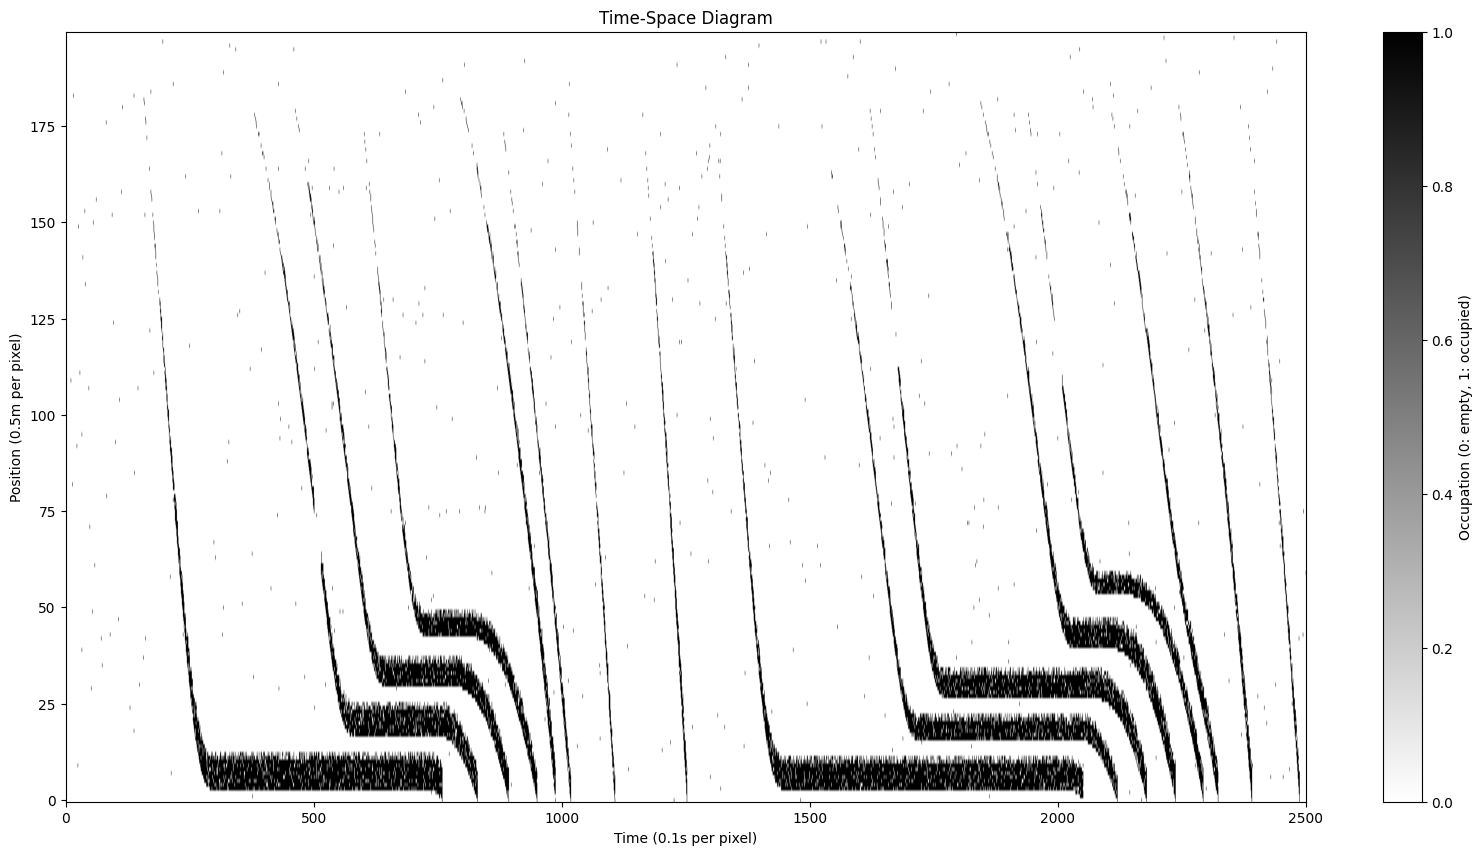

In [38]:
# plt.figure(figsize=(20, 10))
# plt.imshow(occlusion_mask, cmap='binary', aspect='auto', origin='lower')
# plt.title('Time-Space Diagram')
# plt.xlabel('Time (0.1s per pixel)')
# plt.ylabel('Position (0.5m per pixel)')
# plt.colorbar(label='Occupation (0: empty, 1: occupied)')
# plt.xlim(0, 2500)
# plt.show()
# plt.figure(figsize=(20, 10))
# plt.imshow(occluded_diagram, cmap='binary', aspect='auto', origin='lower')
# plt.title('Time-Space Diagram')
# plt.xlabel('Time (0.1s per pixel)')
# plt.ylabel('Position (0.5m per pixel)')
# plt.colorbar(label='Occupation (0: empty, 1: occupied)')
# plt.xlim(0, 2500)
# plt.show()
plt.figure(figsize=(20, 10))
plt.imshow(noised, cmap='binary', aspect='auto', origin='lower')
plt.title('Time-Space Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')
plt.colorbar(label='Occupation (0: empty, 1: occupied)')
plt.xlim(0, 2500)
plt.show()

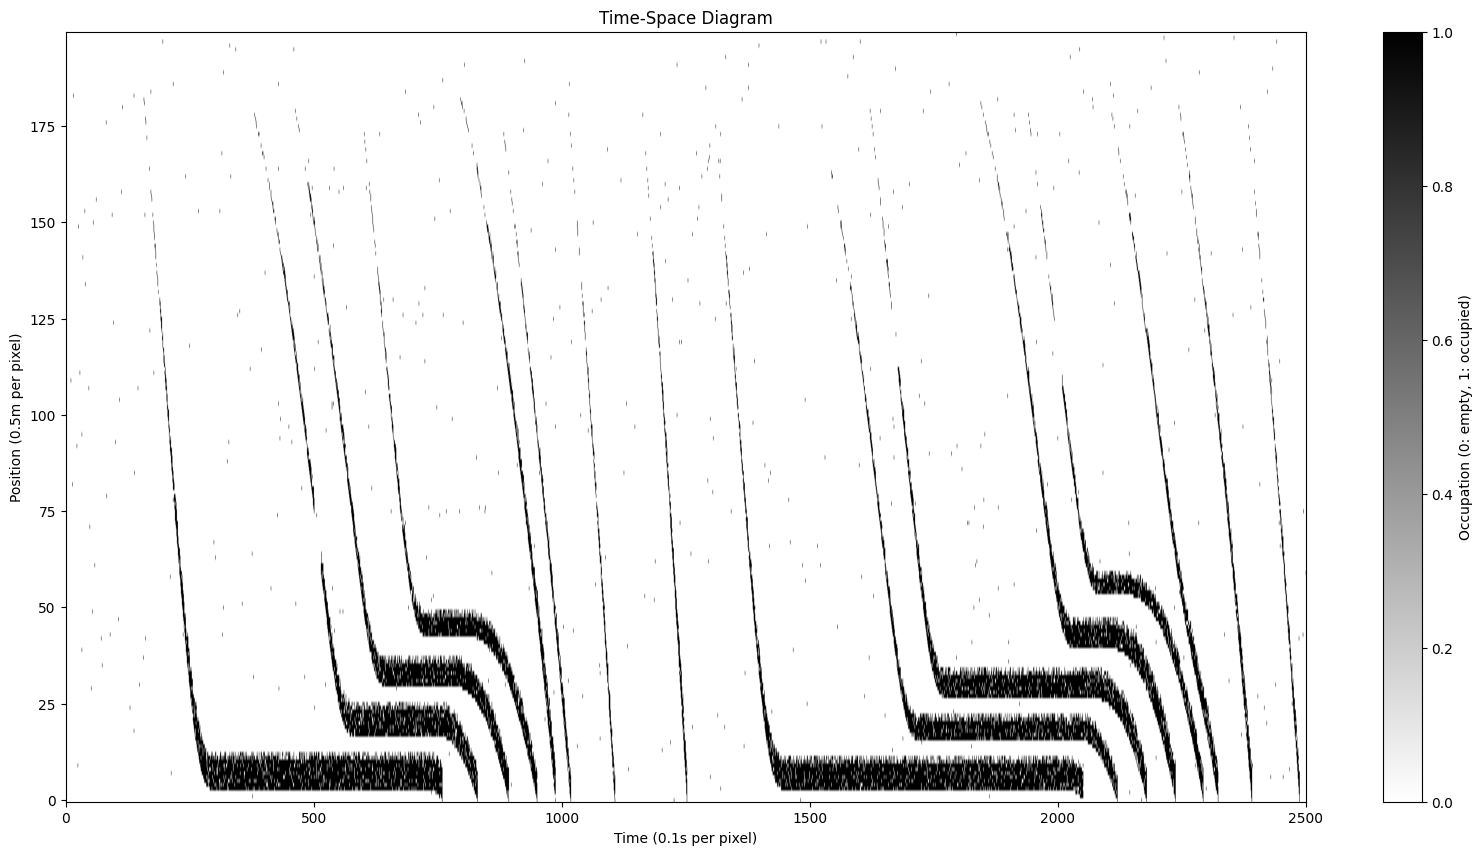

In [41]:
plt.figure(figsize=(20, 10))
plt.imshow(noised, cmap='binary', aspect='auto', origin='lower')
plt.title('Time-Space Diagram')
plt.xlabel('Time (0.1s per pixel)')
plt.ylabel('Position (0.5m per pixel)')
plt.colorbar(label='Occupation (0: empty, 1: occupied)')
plt.xlim(0, 2500)
plt.show()